### Plotting the MCMC Posteriors for Cardinal Data.

In [1]:
#--------------- Packages ---------------#
import os
import sys
import emcee
import random
import fitsio
import Corrfunc
import numpy as np
from classy import Class
import cluster_toolkit as ctk
from astropy.table import Table
import matplotlib.pyplot as plt
from getdist import plots, MCSamples
from colossus.halo import concentration
from chainconsumer import ChainConsumer
from colossus.cosmology import cosmology
from scipy.stats import norm#, multivariate_normal
from colossus.halo import profile_composite, concentration, profile_nfw, profile_einasto
plt.style.use("~/Titus/Lensing/wl_mass_calibration/MNRAS.mplstyle")
plt.rcParams["font.family"] = "Times New Roman"
%matplotlib inline

burnin = 1000
filepath = "/pscratch/sd/t/titus/Cardinal/mcmc_results/"
data_path = r"/global/u2/t/titus/Titus/Lensing/data/"
reader_c_file = filepath+"cardinal_mcmc_testrun_ctk_10per_cov_0.2_0.35_13.0_13.5.h5"

def read_c_file(c_file, burnin):
    labels2 = [r"$\rm \log_{10}\mathit{M}_{vir}$", r"$\rm \mathit{c}_{vir}}$"]
    labels22 = [r"\rm \log_{10}\mathit{M}_{vir}", r"\rm \mathit{c}_{vir}"]
    names = ["M", "c"]
    reader_c = emcee.backends.HDFBackend(c_file)
    samples_c = reader_c.get_chain()
    flat_samples_c = reader_c.get_chain(discard=burnin, flat=True)
    
    lnprob = reader_c.get_log_prob(discard=burnin, flat=True)
    
    posterior_means = np.mean(flat_samples_c, axis=0) #posterior mean
    params = np.array([posterior_means[0], posterior_means[1]])
    
    return flat_samples_c, samples_c, labels2, labels22, names, params

flat_samples_c, samples_c, labels2, labels22, names, params = read_c_file(reader_c_file, burnin)
np.mean(flat_samples_c[:,0])

13.097900408929727

### Plotting all of them together

In [2]:
# Set cardindal cosmology
cosmo_params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.047, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('cardinal', cosmo_params)
cosmo = cosmology.setCosmology('cardinal')
h = cosmo_params['H0']/100

## Cluster toolkit cosmology
#Start by specifying the cosmology
Omega_b = cosmo_params['Ob0']
Omega_m = cosmo_params['Om0']
Omega_cdm = Omega_m - Omega_b
sigma8 = cosmo_params['sigma8']
h = cosmo_params['H0']/100 # McClintock h value
n_s = cosmo_params['ns']
# z = 0.3

#Create a params dictionary
#Need to specify the max wavenumber
k_max = 1000 #UNITS: 1/Mpc

params = {
         'output':'mPk',
         'h':h,
         'sigma8':sigma8,
         'n_s':n_s,
         'Omega_b':Omega_b,
         'Omega_cdm':Omega_cdm,
         'P_k_max_1/Mpc':k_max,
         'z_max_pk':1.0, #Default value is 10
         'non linear':'halofit'
}

#Initialize the cosmology and compute everything
cosmo_ctk = Class()
cosmo_ctk.set(params)
cosmo_ctk.compute()

In [3]:
def log_likelihood(params, rp, z, input_units = "physical"):
    log10_M, c = params
    M = (10**log10_M) #Msun/h

    a = 1/(1+z) # scale factor
    Rproj = np.logspace(-2, 2.4, num=1000, base=10) #Mpc/h Projected 2D radii. 
    R3d = np.logspace(-2, 3, num=1000, base=10) #Mpc/h comoving. 3D radii.
    
    # McClintock radial bins
    Rmin = 0.0323
    Rmax = 30
    nbins = 15
    Redges = np.logspace(np.log10(Rmin), np.log10(Rmax), nbins+1) #Projected radial bin edges
    Redges *= h*(1+z)

    """
    Note:
    Minimum Rproj for Sigma(Rproj) must be >= than min(r) of xi(r).
    Maximum Rproj for Sigma(Rproj) must be <= than max(r) of xi(r).
    Thus, the range of values for Rproj must be 
    equal to (or contained in) that of r
    """
    
    #Specify k and z
    # k = np.logspace(-5, 3, num=4000) #Mpc^-1 comoving
    k = np.logspace(-5, np.log10(k_max), num=4000) #Mpc^-1 comoving
    # Power spectrum
    Pnonlin = np.array([cosmo_ctk.pk(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    Plin = np.array([cosmo_ctk.pk_lin(ki, z) for ki in k])#*h**3  #Mpc^3/h^3 comoving
    kh = k/h #h/Mpc comoving
    # k /= h #h/Mpc comoving
    #P(k) are in Mpc^3/h^3 comoving
    #Thus, you will need to convert these to h/Mpc and (Mpc/h)^3 to use in the toolkit.
    Plin *= h**3
    Pnonlin *= h**3

    # NFW profile
    xi_nfw = ctk.xi.xi_nfw_at_r(R3d, M, c, Omega_m, delta=200) #delta=200 by default

    # # Matter-matter correlation function (matter auto-correlation)
    xi_mm = ctk.xi.xi_mm_at_r(R3d, kh, Pnonlin)

    # 2-halo correlation function
    bias_term = ctk.bias.bias_at_M(M, kh, Plin, Omega_m, delta=200) # Here, P must be linear. #delta=200 by default
    xi_2halo = ctk.xi.xi_2halo(bias_term, xi_mm)

    # Halo-matter correlation function
    xi_hm = ctk.xi.xi_hm(xi_nfw, xi_2halo)

    # Sigma (computed from xi_hm)
    Sigma = ctk.deltasigma.Sigma_at_R(Rproj, R3d, xi_hm, M, c, Omega_m, delta=200) #delta=200 by default
    # Sigma = ctk.deltasigma.Sigma_nfw_at_R(Rproj, M, c, Omega_m, delta=200)

    # DeltaSigma (excess surface density)
    DS = ctk.deltasigma.DeltaSigma_at_R(Rproj, Rproj, Sigma, M, c, Omega_m, delta=200) #delta=200 by default
    ave_DS = ctk.averaging.average_profile_in_bins(Redges, Rproj, DS)
    
    if input_units == "physical":
        model_ctk = ave_DS*h*(1+z)**2 #convert to Msun/pc^2 physical
    else:
        model_ctk = ave_DS
    
    #################################################
    ## Colossus profile
    rp_phys = (rp*1e3)*h #kp/h physical
    p_nfw = profile_nfw.NFWProfile(M = M, c = c, z = z, mdef = '200m') #cardinal overdensity definition is vir
    
    p_einasto = profile_einasto.EinastoProfile(M = M, c = c, z = z, mdef = '200m') #cardinal overdensity definition is vir

    #-------------Calculating Delta Sigma for nfw and einasto profile
    ## nfw
    ds_nfw = p_nfw.deltaSigma(rp_phys)
    ## einasto
    ds_einasto = p_einasto.deltaSigma(rp_phys)
    
    if input_units == "physical":
        ds_theory_nfw = h*ds_nfw*1e-6  # colossus works in physical units; hence, there is no need to do ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*1e-6  # colossus works in physical units; hence, there is no need to do ds_einasto*a**2*1e-6 
    else:
        ds_theory_nfw = h*ds_nfw*a**2*1e-6  
        ds_theory_einasto = h*ds_einasto*a**2*1e-6  
    ############################################
    return model_ctk#, ds_theory_nfw, ds_theory_einasto #DS_model#, ave_DS

### Overlaying contours on each other.

In [4]:
#############################################
#############################################
Rmin_phys_mpc = 0.0323
Rmax_phys_mpc = 30
nbins_phys_mpc = 15
lnrp_bins_phys_mpc = np.linspace(np.log(Rmin_phys_mpc), np.log(Rmax_phys_mpc), nbins_phys_mpc+1)
rp_bins_phys_mpc = np.exp(lnrp_bins_phys_mpc)
rp_phys_mpc = np.sqrt(rp_bins_phys_mpc[:-1]*rp_bins_phys_mpc[1:])
rp = rp_phys_mpc
sel = rp > 0.20
# sel = (rp > 0.10)&(rp < 9)
rp1 = rp[sel]

z bin = [0.2, 0.35]
Mass bin = [20, 30]
True mass = 14.256152153015137


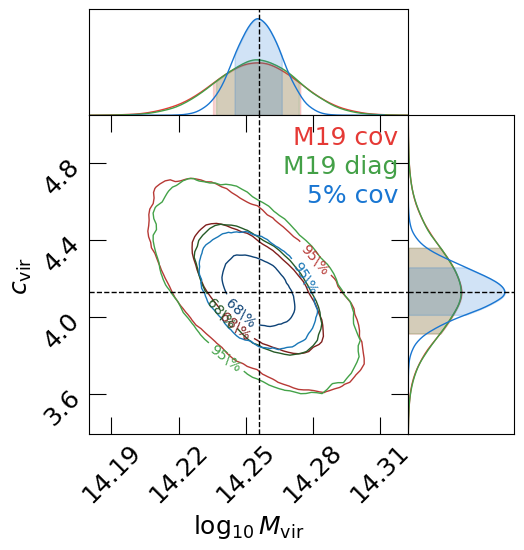

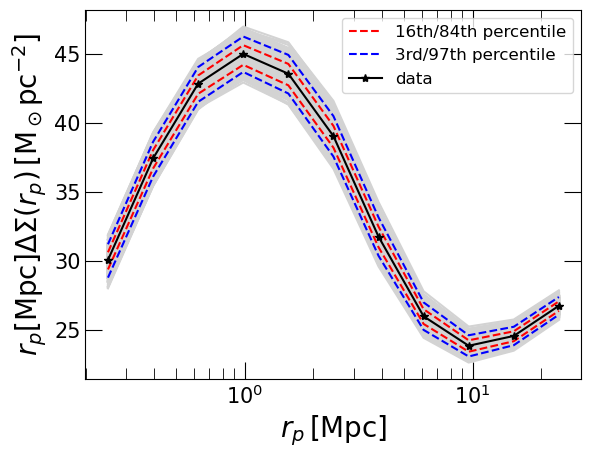

z bin = [0.2, 0.35]
Mass bin = [30, 45]
True mass = 14.481986999511719


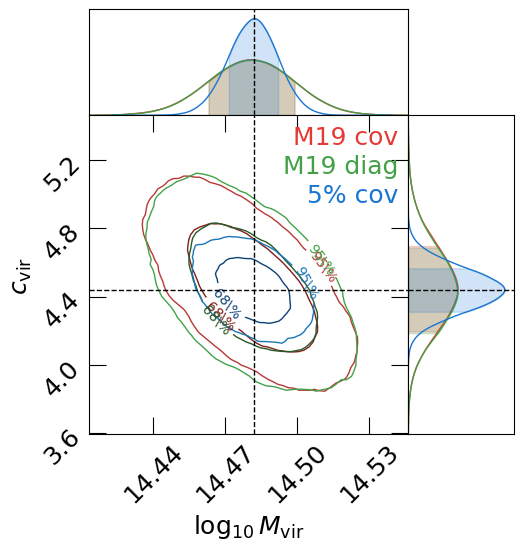

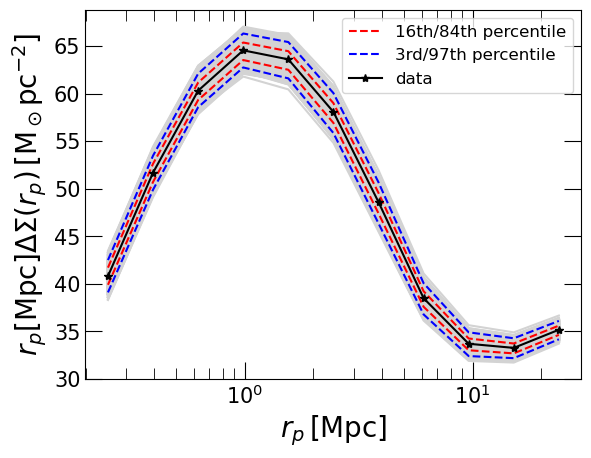

z bin = [0.2, 0.35]
Mass bin = [45, 60]
True mass = 14.567497253417969


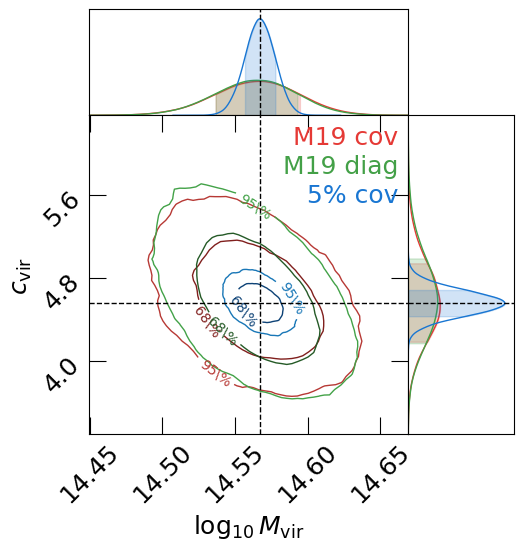

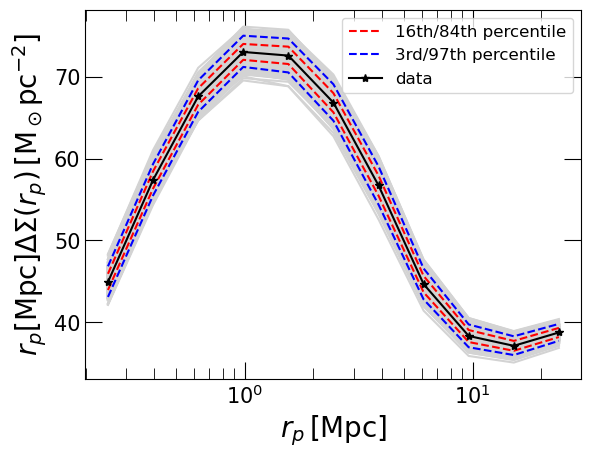

z bin = [0.2, 0.35]
Mass bin = [60, 500]
True mass = 14.776834487915039


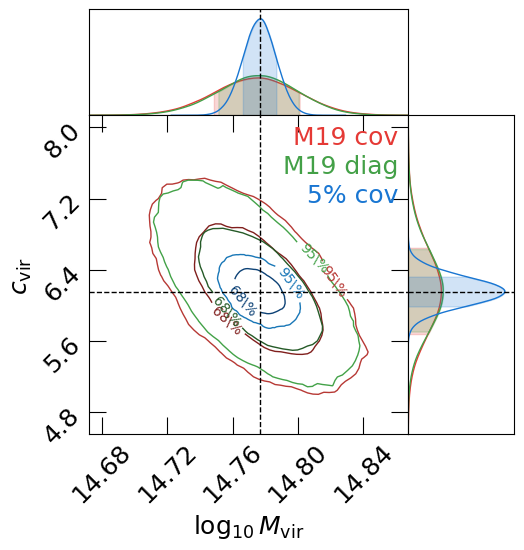

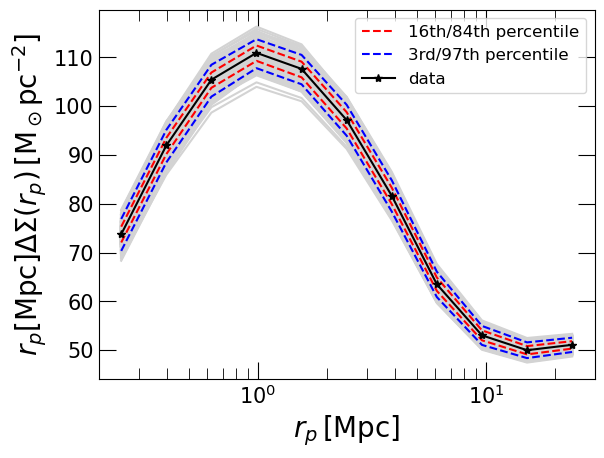

z bin = [0.35, 0.5]
Mass bin = [20, 30]
True mass = 14.0364408493042


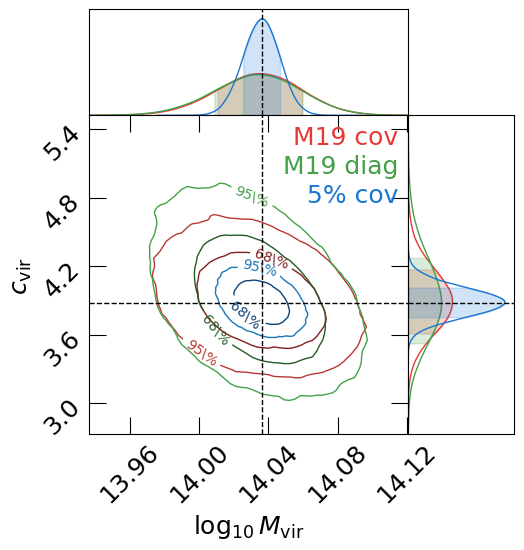

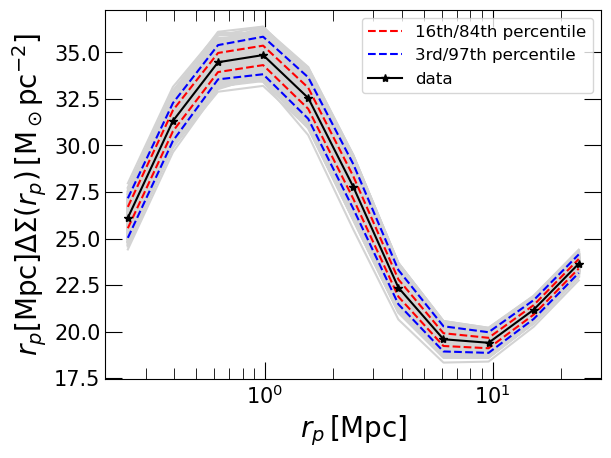

z bin = [0.35, 0.5]
Mass bin = [30, 45]
True mass = 14.268896102905273


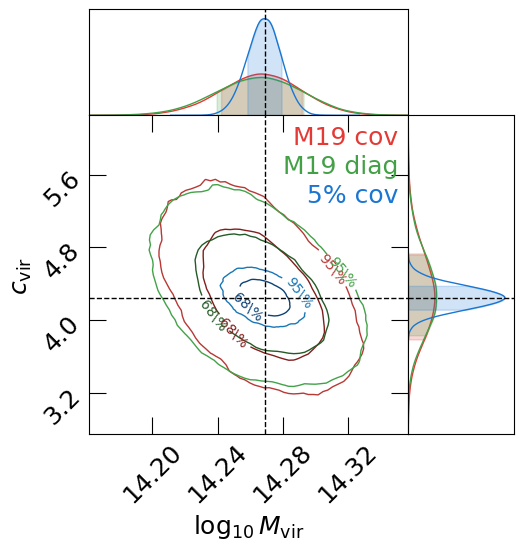

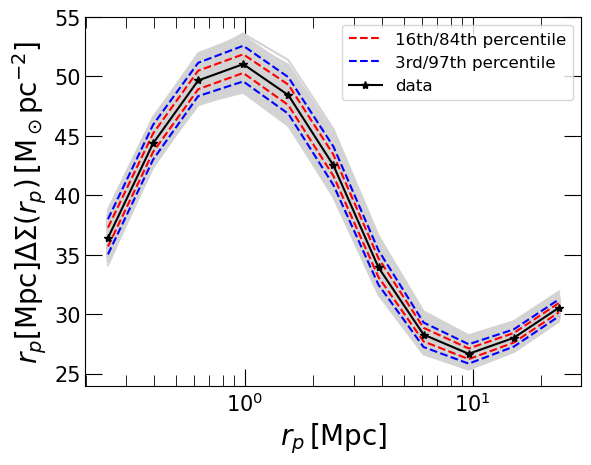

z bin = [0.35, 0.5]
Mass bin = [45, 60]
True mass = 14.446784973144531


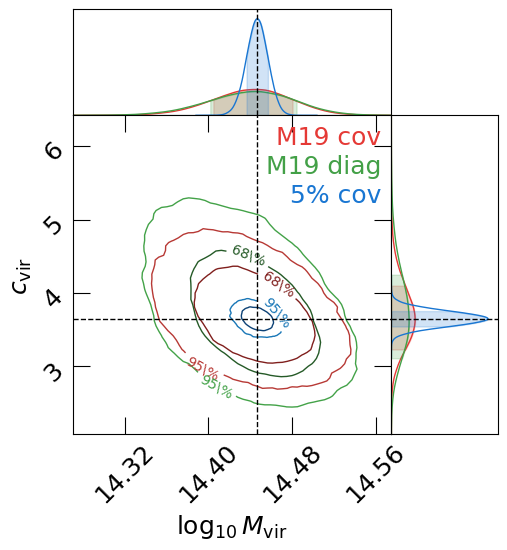

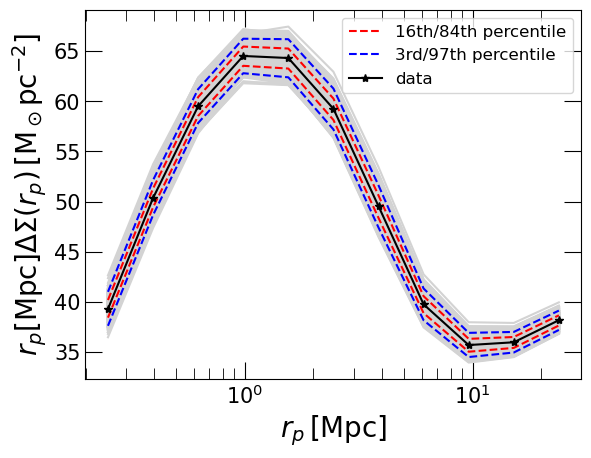

z bin = [0.35, 0.5]
Mass bin = [60, 500]
True mass = 14.660221099853516


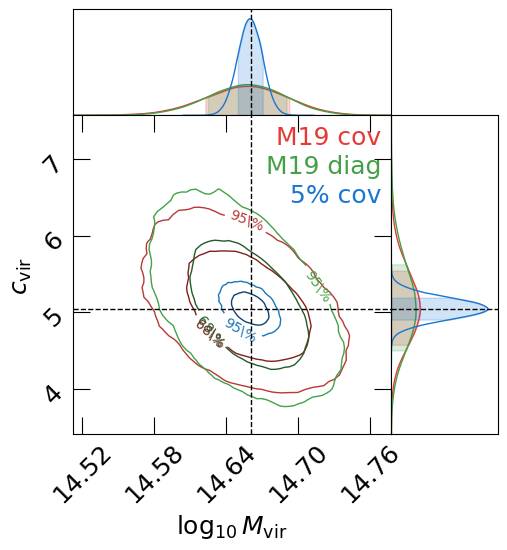

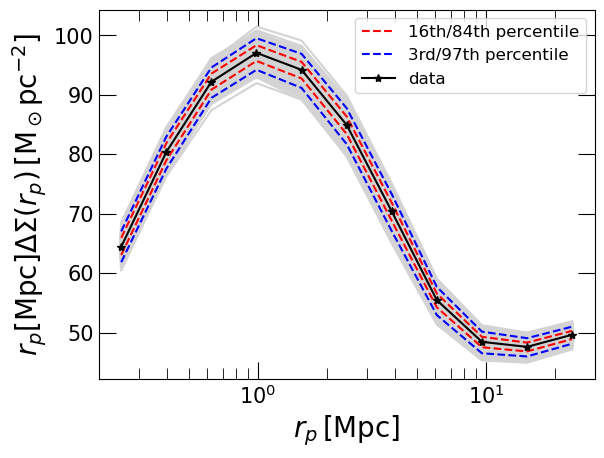

z bin = [0.5, 0.7]
Mass bin = [20, 30]
True mass = 13.925470352172852


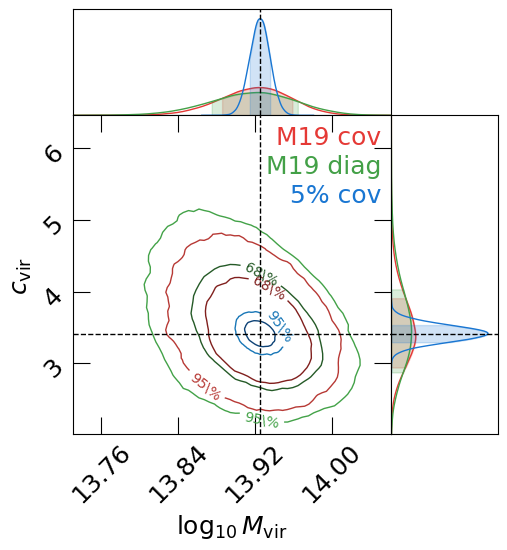

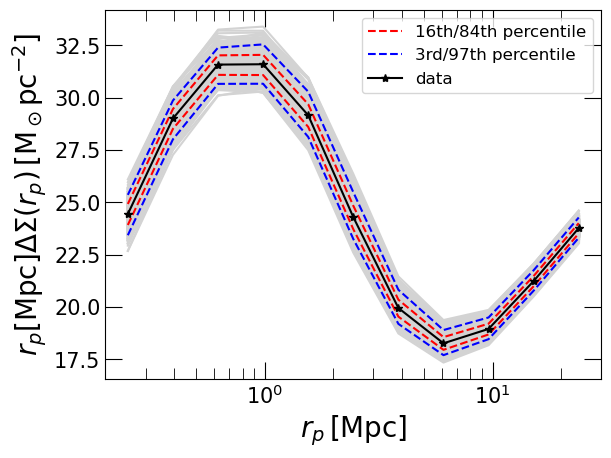

z bin = [0.5, 0.7]
Mass bin = [30, 45]
True mass = 14.175905227661133


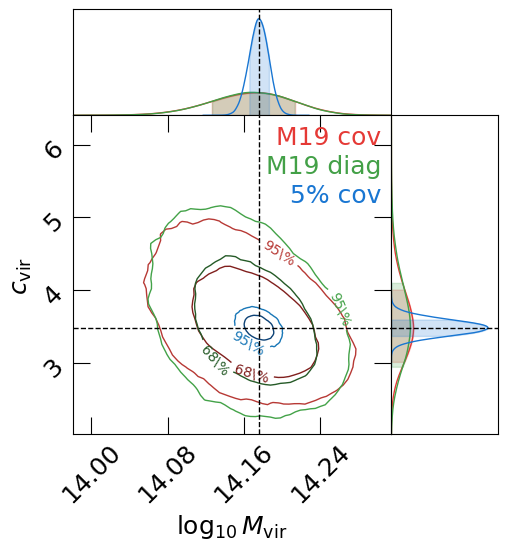

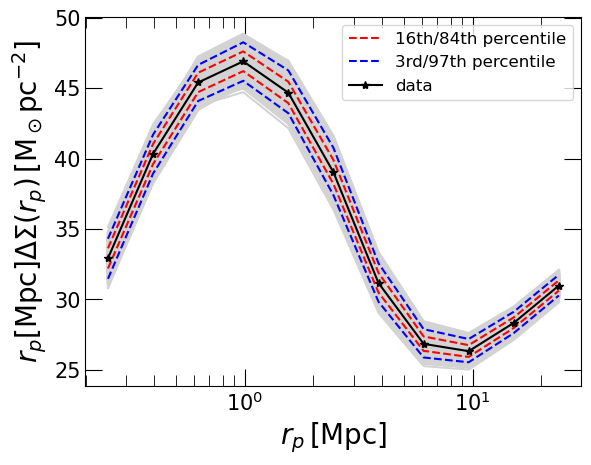

z bin = [0.5, 0.7]
Mass bin = [45, 60]
True mass = 14.392958641052246


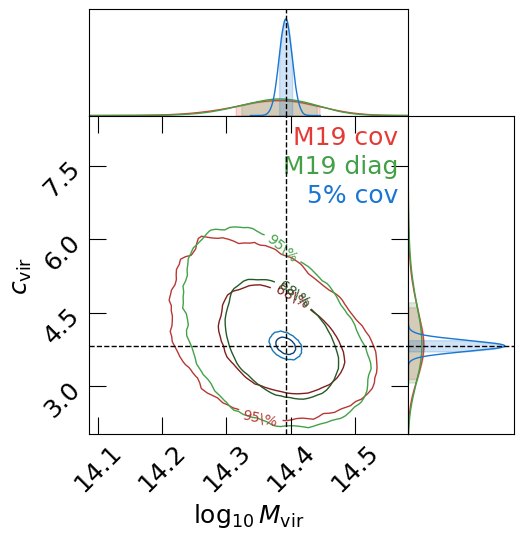

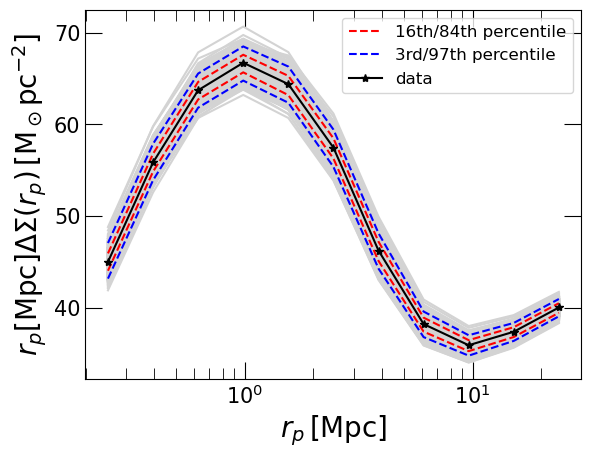

In [5]:
### Load the halos with the DS and Sigma profiles
halos_ds =  Table(np.load(data_path+"stacked_DS_halo_run.npy", allow_pickle=True))
cosmo_params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.047, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('cardinal', cosmo_params)
cosmo = cosmology.setCosmology('cardinal')
h = cosmo_params['H0']/100

z_lower = [0.2, 0.2, 0.2, 0.2, 0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5]
z_upper = [0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7]
lambda_lower = [20, 30, 45, 60, 20, 30, 45, 60, 20, 30, 45, 60]
lambda_upper = [30, 45, 60, 500, 30, 45, 60, 500, 30, 45, 60, 500]

for i in range(len(halos_ds)-1):
# for i in range(4):
    # run_name0 = "_testrun_ctk_halorun_modelasdata_m19_cov"
    # run_name1 = "_testrun_ctk_halorun_modelasdata_m19_diag_cov"
    # run_name2 = "_testrun_ctk_halorun_modelasdata_5per_cov"
    
    run_name0 = "_fullrun_ctk_halorun_modelasdata_m19_cov"
    run_name1 = "_fullrun_ctk_halorun_modelasdata_m19_diag_cov"
    run_name2 = "_fullrun_ctk_halorun_modelasdata_5per_cov"
    readerfile0 = filepath+f"cardinal_mcmc{run_name0}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    readerfile1 = filepath+f"cardinal_mcmc{run_name1}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    readerfile2 = filepath+f"cardinal_mcmc{run_name2}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    z = halos_ds["Redshift"][i]
    log10_M = halos_ds["Mvir"][i]

    c = halos_ds["cvir"][i]
    true_params = np.array([log10_M, c])
    print(f"z bin = [{z_lower[i]}, {z_upper[i]}]")
    print(f"Mass bin = [{lambda_lower[i]}, {lambda_upper[i]}]")
    print(f"True mass = {log10_M}")

    # read MCMC files
    flat_samples_c_0, samples_c_0, labels2_0, labels22_0, names_0, params_0 = read_c_file(readerfile0, burnin)
    flat_samples_c_1, samples_c_1, labels2_1, labels22_1, names_1, params_1 = read_c_file(readerfile1, burnin)
    flat_samples_c_2, samples_c_2, labels2_2, labels22_2, names_2, params_2 = read_c_file(readerfile2, burnin)
    data_ds = log_likelihood(true_params, rp, z, input_units = "physical")
    model_ctk0 = log_likelihood(params_0, rp, z, input_units = "physical")
    model_ctk1 = log_likelihood(params_1, rp, z, input_units = "physical")
    model_ctk2 = log_likelihood(params_2, rp, z, input_units = "physical")

    ######################################################
    chain = ChainConsumer()
    chain.add_chain(flat_samples_c_0, parameters=labels2_0, name="M19 cov")
    chain.add_chain(flat_samples_c_1, parameters=labels2_1, name="M19 diag")
    chain.add_chain(flat_samples_c_2, parameters=labels2_2, name="5% cov")
    
    ##############
    chain.configure(summary=True, spacing=0.0, diagonal_tick_labels=True, 
                    tick_font_size=18, label_font_size=18, max_ticks=5, 
                    # shade=True, shade_alpha=[0.1, 0.5, 0.9],
                    shade_gradient=1.0, colors=['red', 'green', 'blue'], sigma2d=False,
                    # sigmas=[1, 2, 3], shade_alpha=[1.0, 0.5, 0.35], smooth = 10.0, #smooth = True,  #kde = True,
                    sigmas=[1,2], shade_alpha=[0.0, 0.0, 0.0], smooth = True, kde = True,
                    summary_area=0.6827, contour_labels = "confidence", 
                    contour_label_font_size = 10, flip=True, bar_shade=True)
    chain.configure_truth(color='k', ls="--", alpha=1.0)
    chain.analysis.get_summary(parameters=labels2)
    
    #############
    fig = chain.plotter.plot(display=True, figsize="column", truth=true_params)
    fig.set_size_inches(11 + fig.get_size_inches())  # Resize fig for doco. You don't need this.


    #####################################################
        # Assuming flat_samples_c, rp1, and other necessary variables are defined
    model_ctk_profiles_M19_cov = []
    model_ctk_profiles_M19_diag = []
    model_ctk_profiles_5per_cov = []

    # Generate a list of unique random integers from the range
    indexes = random.sample(range(1000, len(flat_samples_c_0)), 5000) 
    
    # Step 2: Compute the DeltaSigma profile for each selected set of parameters
    for index in indexes:  # indexes already defined as a list of random indices
        index_params_5per_cov = flat_samples_c_2[index]
        index_model_ctk_5per_cov = log_likelihood(index_params_5per_cov, rp, z, input_units="physical")
        model_ctk_profiles_5per_cov.append((rp1 * index_model_ctk_5per_cov[sel]))
        plt.plot(rp1, (rp1*index_model_ctk_5per_cov[sel]), '-', c='lightgrey')

    # Convert to numpy array for easier percentile computation
    model_ctk_profiles_5per_cov = np.array(model_ctk_profiles_5per_cov)

    # Step 4: Compute the 3rd and 97th percentiles
    percentile_3rd_5per_cov = np.percentile(model_ctk_profiles_5per_cov, 3, axis=0)
    percentile_97th_5per_cov = np.percentile(model_ctk_profiles_5per_cov, 97, axis=0)
    
    # Step 5: Compute the 3rd and 97th percentiles
    percentile_16th_5per_cov = np.percentile(model_ctk_profiles_5per_cov, 16, axis=0)
    percentile_84th_5per_cov = np.percentile(model_ctk_profiles_5per_cov, 84, axis=0)

    # Plotting
    plt.xscale("log")
    plt.xlabel(r"$\rm \mathit{r_p}\,[\mathrm{Mpc}]$", fontsize=20)
    plt.ylabel(r"$\rm \mathit{r_p}[\mathrm{Mpc}] \Delta\Sigma(\mathit{r_p})\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=20)

    # Step 6: Plot the percentiles
    plt.plot(rp1, percentile_16th_5per_cov, '--', c='red', label='16th/84th percentile')
    plt.plot(rp1, percentile_84th_5per_cov, '--', c='red')
    
    ##################################################
    plt.plot(rp1, percentile_3rd_5per_cov, '--', c='blue', label='3rd/97th percentile')
    plt.plot(rp1, percentile_97th_5per_cov, '--', c='blue')

    # Plot the data for comparison  
    plt.plot(rp1, rp1*data_ds[sel], '-*', c='k', label='data')

    plt.legend()
    plt.show()

z bin = [0.2, 0.35]
Mass bin = [20, 30]
True mass = 14.256152153015137


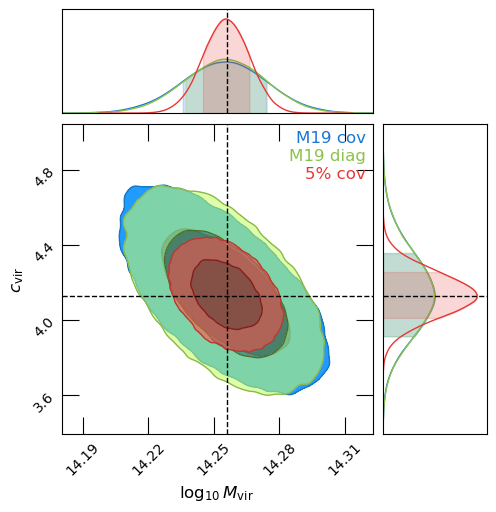

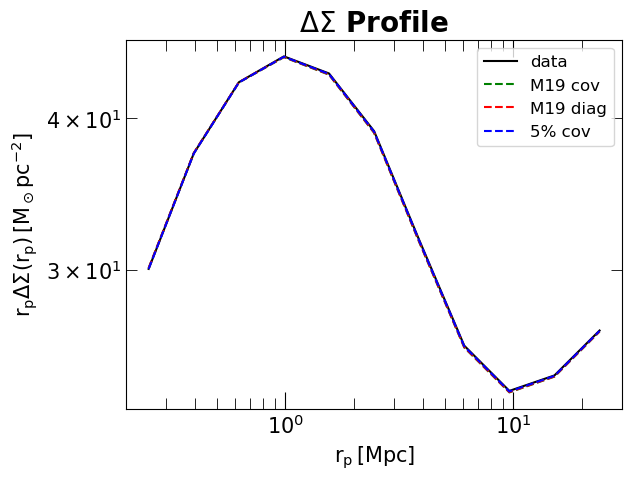

z bin = [0.2, 0.35]
Mass bin = [30, 45]
True mass = 14.481986999511719


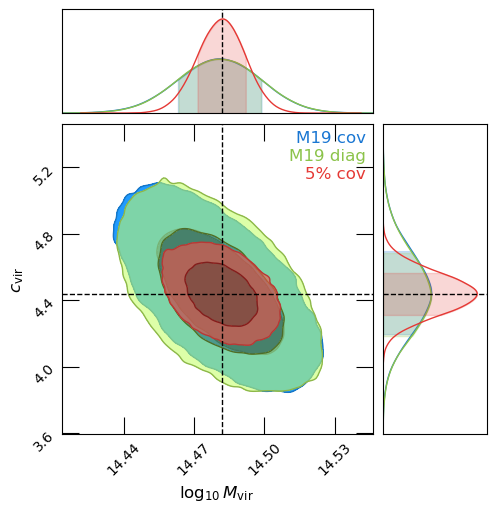

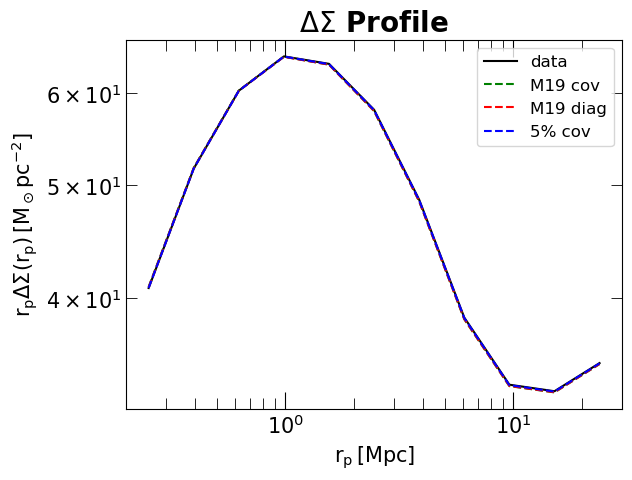

z bin = [0.2, 0.35]
Mass bin = [45, 60]
True mass = 14.567497253417969


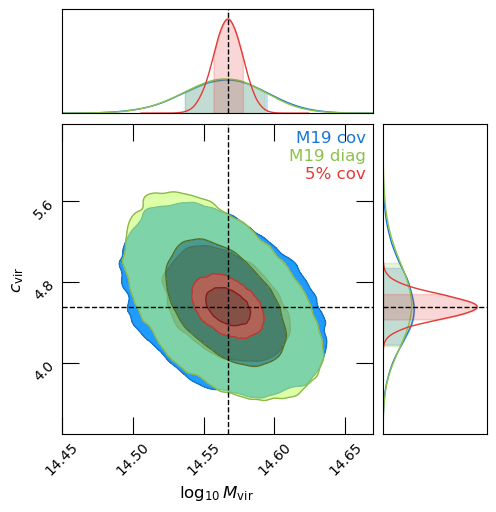

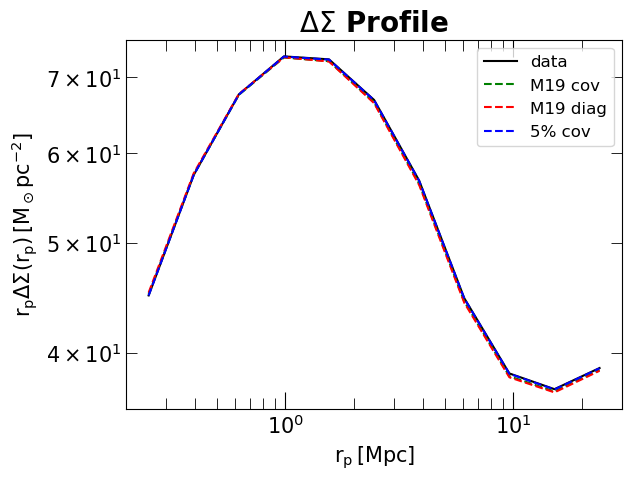

z bin = [0.2, 0.35]
Mass bin = [60, 500]
True mass = 14.776834487915039


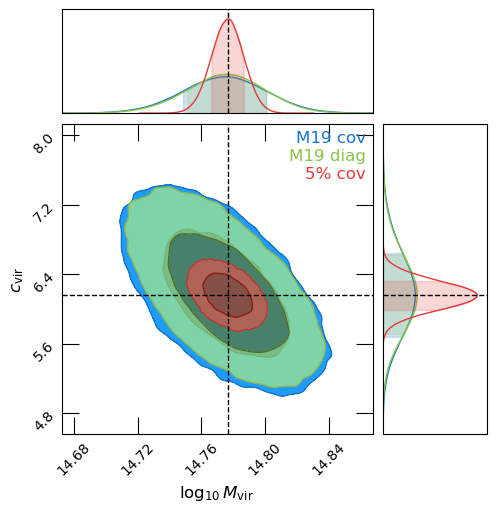

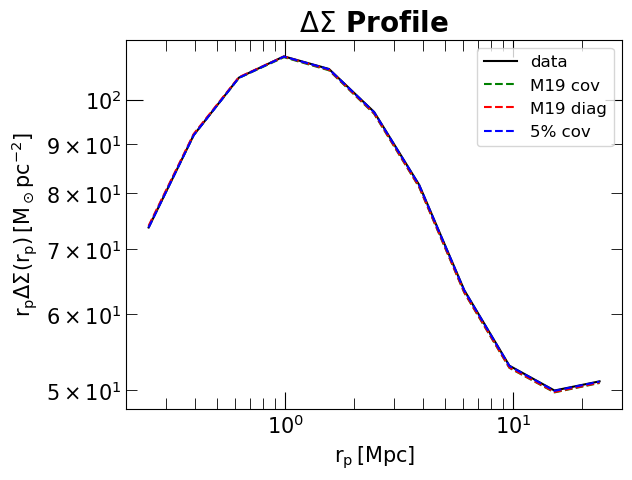

z bin = [0.35, 0.5]
Mass bin = [20, 30]
True mass = 14.0364408493042


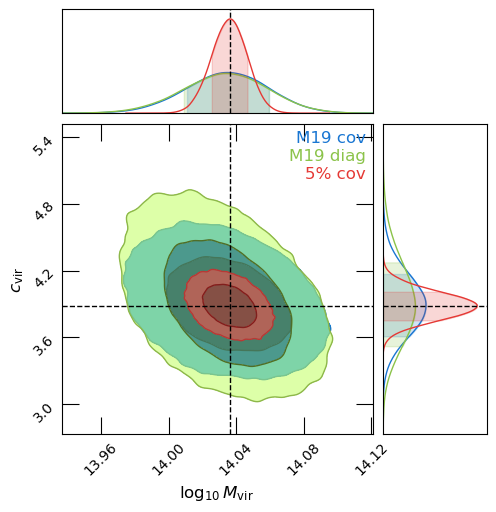

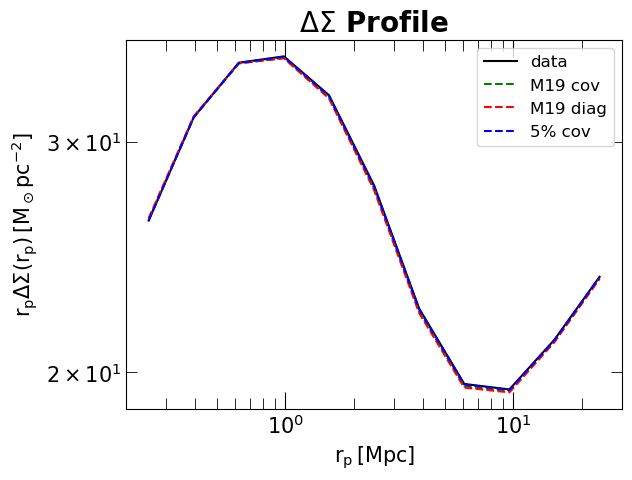

z bin = [0.35, 0.5]
Mass bin = [30, 45]
True mass = 14.268896102905273


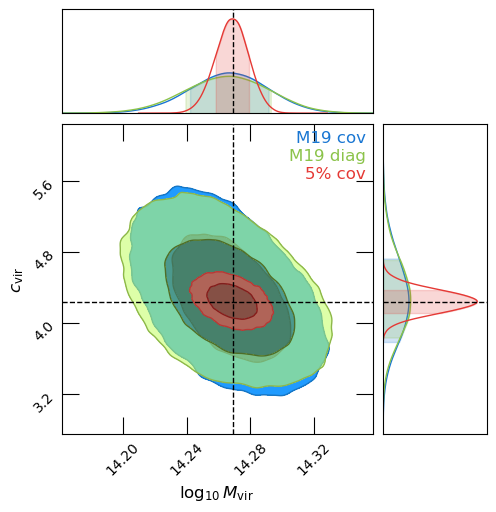

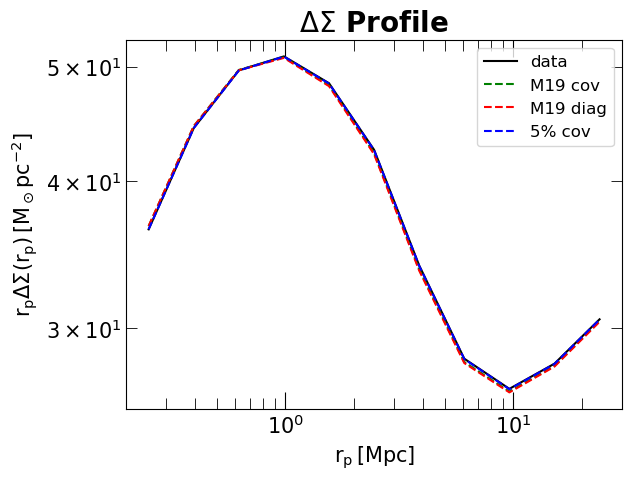

z bin = [0.35, 0.5]
Mass bin = [45, 60]
True mass = 14.446784973144531


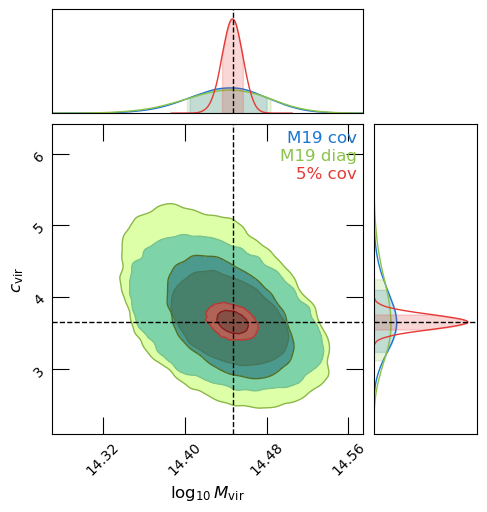

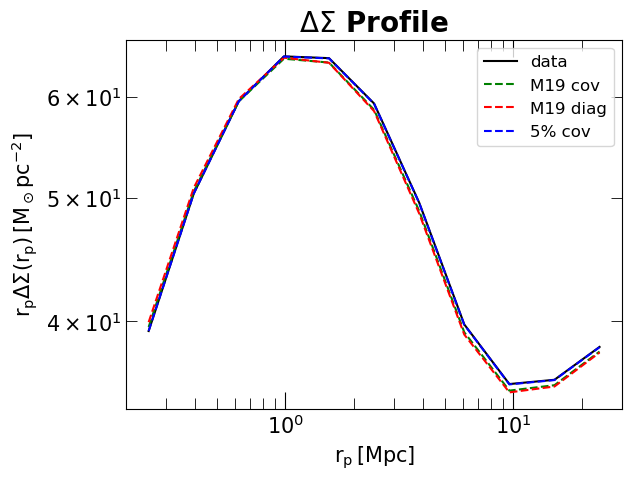

z bin = [0.35, 0.5]
Mass bin = [60, 500]
True mass = 14.660221099853516


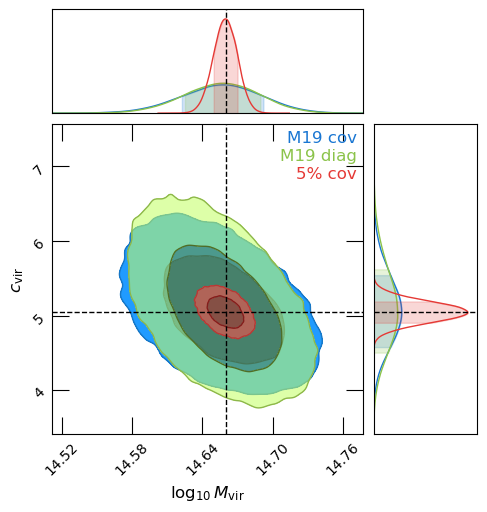

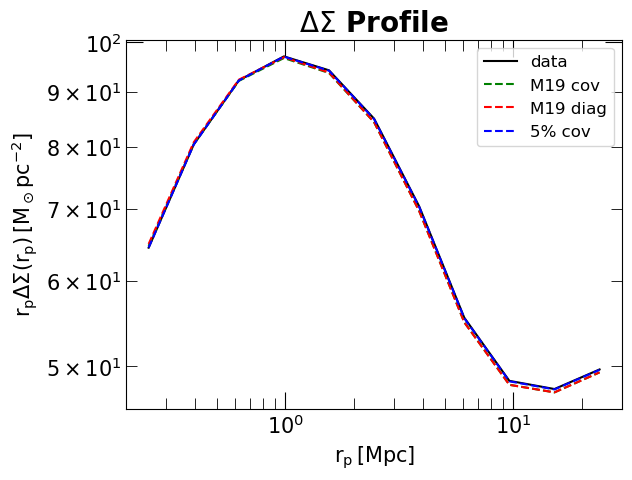

z bin = [0.5, 0.7]
Mass bin = [20, 30]
True mass = 13.925470352172852


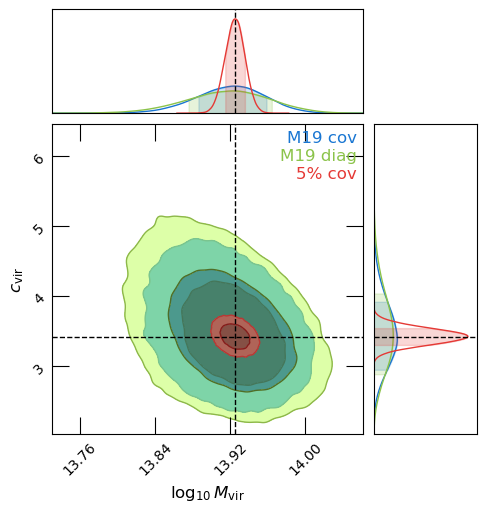

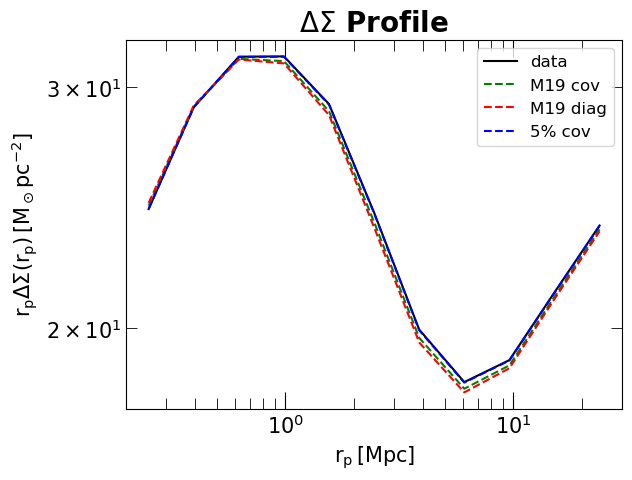

z bin = [0.5, 0.7]
Mass bin = [30, 45]
True mass = 14.175905227661133


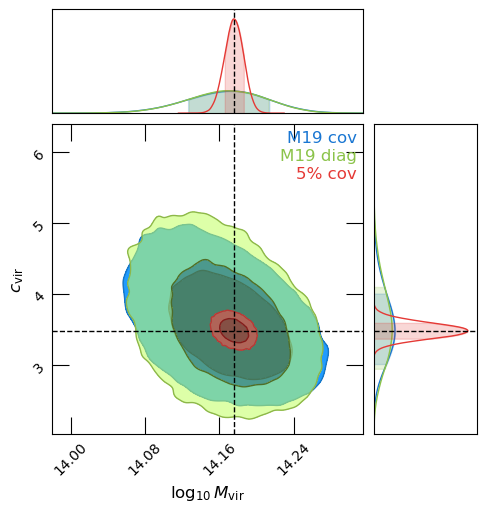

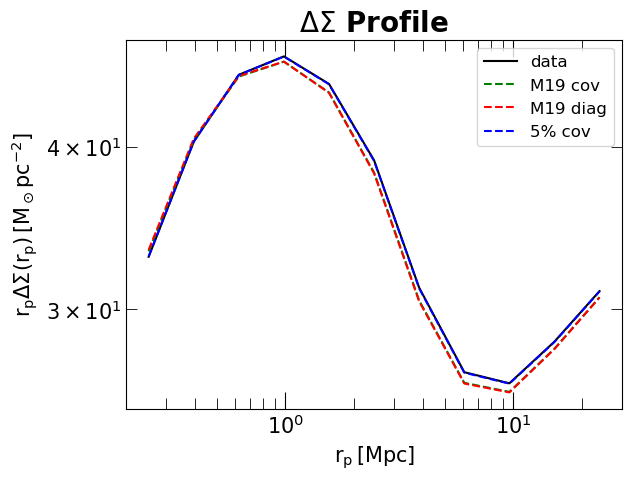

z bin = [0.5, 0.7]
Mass bin = [45, 60]
True mass = 14.392958641052246


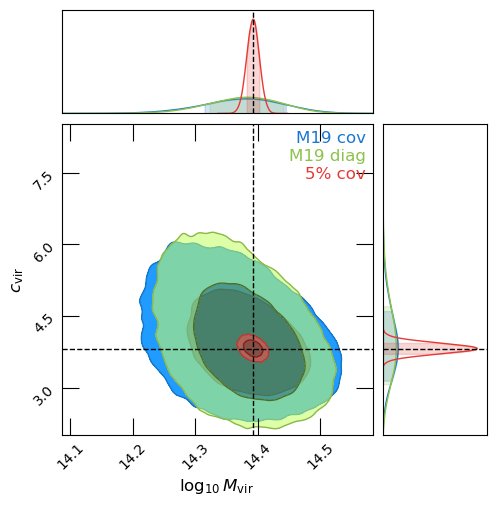

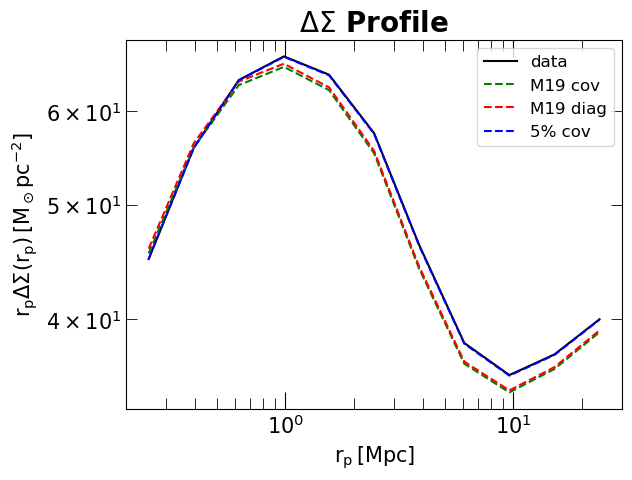

In [8]:
### Load the halos with the DS and Sigma profiles
halos_ds =  Table(np.load(data_path+"stacked_DS_halo_run.npy", allow_pickle=True))
cosmo_params = {'flat': True, 'H0': 70, 'Om0': 0.286, 'Ob0': 0.047, 'sigma8': 0.82, 'ns': 0.96}
cosmology.addCosmology('cardinal', cosmo_params)
cosmo = cosmology.setCosmology('cardinal')
h = cosmo_params['H0']/100

z_lower = [0.2, 0.2, 0.2, 0.2, 0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5]
z_upper = [0.35, 0.35, 0.35, 0.35, 0.5, 0.5, 0.5, 0.5, 0.7, 0.7, 0.7, 0.7]
lambda_lower = [20, 30, 45, 60, 20, 30, 45, 60, 20, 30, 45, 60]
lambda_upper = [30, 45, 60, 500, 30, 45, 60, 500, 30, 45, 60, 500]

for i in range(len(halos_ds)-1):
    # run_name0 = "_testrun_ctk_halorun_modelasdata_m19_cov"
    # run_name1 = "_testrun_ctk_halorun_modelasdata_m19_diag_cov"
    # run_name2 = "_testrun_ctk_halorun_modelasdata_5per_cov"
    
    run_name0 = "_fullrun_ctk_halorun_modelasdata_m19_cov"
    run_name1 = "_fullrun_ctk_halorun_modelasdata_m19_diag_cov"
    run_name2 = "_fullrun_ctk_halorun_modelasdata_5per_cov"
    readerfile0 = filepath+f"cardinal_mcmc{run_name0}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    readerfile1 = filepath+f"cardinal_mcmc{run_name1}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    readerfile2 = filepath+f"cardinal_mcmc{run_name2}_{z_lower[i]}_{z_upper[i]}_{lambda_lower[i]}_{lambda_upper[i]}.h5"
    z = halos_ds["Redshift"][i]
    log10_M = halos_ds["Mvir"][i]

    c = halos_ds["cvir"][i]
    true_params = np.array([log10_M, c])
    print(f"z bin = [{z_lower[i]}, {z_upper[i]}]")
    print(f"Mass bin = [{lambda_lower[i]}, {lambda_upper[i]}]")
    print(f"True mass = {log10_M}")
    # print(c0,c)

    flat_samples_c_0, samples_c_0, labels2_0, labels22_0, names_0, params_0 = read_c_file(readerfile0, burnin)
    flat_samples_c_1, samples_c_1, labels2_1, labels22_1, names_1, params_1 = read_c_file(readerfile1, burnin)
    flat_samples_c_2, samples_c_2, labels2_2, labels22_2, names_2, params_2 = read_c_file(readerfile2, burnin)
    data_ds = log_likelihood(true_params, rp, z, input_units = "physical")
    model_ctk0 = log_likelihood(params_0, rp, z, input_units = "physical")
    model_ctk1 = log_likelihood(params_1, rp, z, input_units = "physical")
    model_ctk2 = log_likelihood(params_2, rp, z, input_units = "physical")

    ######################################################
    # If you pass in parameter labels and only one chain, you can also get parameter bounds
    chain = ChainConsumer()
    chain.add_chain(flat_samples_c_0, parameters=labels2_0, name="M19 cov")
    chain.configure(summary=True, spacing=0.0, diagonal_tick_labels=True, 
                    tick_font_size=16, label_font_size=18, max_ticks=5, 
                    shade_gradient=0.75, sigma2d=False,
                    sigmas=[1, 2, 3], shade_alpha=[1.0, 0.5, 0.1], smooth = 10, #smooth = True,  #kde = True,
                    summary_area=0.6827, contour_labels = "confidence", 
                    contour_label_font_size = 10, flip=True, bar_shade=True)
    chain.configure_truth(color='k', ls="--", alpha=1.0)
    chain.analysis.get_summary(parameters=labels2)
    chain.add_chain(flat_samples_c_1, parameters=labels2_1, name="M19 diag")
    chain.add_chain(flat_samples_c_2, parameters=labels2_2, name="5% cov")
    fig = chain.plotter.plot(display=True, figsize="column", truth=true_params)

    fig.set_size_inches(11 + fig.get_size_inches())  # Resize fig for doco. You don't need this.
    #####################################################
    
    plt.loglog()
    plt.title(r"$\Delta \Sigma$ Profile", fontsize = 20)
    plt.xlabel(r"$\rm r_p\,[\mathrm{Mpc}]$", fontsize = 15)
    plt.ylabel(r"$\rm r_p \Delta\Sigma(r_p)\,[M_\odot \mathrm{pc}^{-2}]$", fontsize = 15)
    plt.plot(rp1, rp1*data_ds[sel], ls='-', c='k', label='data')
    plt.plot(rp1, rp1*model_ctk0[sel], ls='--', c='g', label='M19 cov')
    plt.plot(rp1, rp1*model_ctk1[sel], ls='--', c='r', label='M19 diag')
    plt.plot(rp1, rp1*model_ctk2[sel], ls='--', c='b', label='5% cov')
    plt.legend()
    plt.show()

### Plotting Covariances

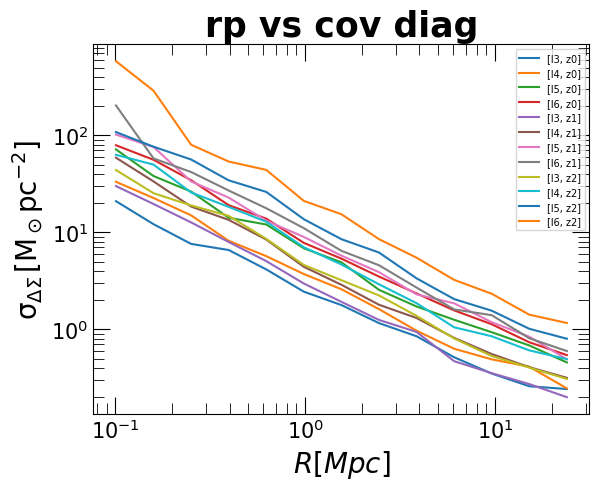

In [14]:
rp_path = "/global/u2/t/titus/Titus/lambda_cov/cluster-lensing-cov/examples/lam_cov_matrix_cardinal_sqrt84/"
cov_path = '/global/u2/t/titus/Titus/Lensing/data/McClintock_data/desy1_tamas/'
l = ["3", "4", "5", "6", "3", "4", "5", "6", "3", "4", "5", "6"]
z = ["0", "0", "0", "0", "1", "1", "1", "1", "2", "2", "2", "2"]

Rp = np.loadtxt(rp_path+'rp_hiMpc.dat')[:, 2]
sel = Rp > 0.1
for i in range(len(z)):
    lambda_min, lambda_max = load_lambda_bins[str(i)]
    cov = cov_path+"full-unblind-v2-mcal-zmix_y1subtr_l"+l[i]+"_z"+z[i]+"_dst_cov.dat"
    combine_cov = np.loadtxt(cov)
    combine_cov = combine_cov[sel]
    combine_cov = combine_cov[:,sel]
    combine_cov = combine_cov
    diag = np.sqrt((np.diag(combine_cov))) #cov has h but data has no h.
    plt.loglog()
    plt.plot(Rp[sel], diag, label = f'[l{l[i]}, z{z[i]}]')
plt.title("rp vs cov diag", fontsize=25)
plt.xlabel(r"$R [Mpc]$", fontsize=20)
plt.ylabel(r"$\rm \sigma_{\Delta\Sigma\,}[M_\odot \mathrm{pc}^{-2}]$", fontsize=20)
plt.legend(fontsize=7)
plt.show()
# diag

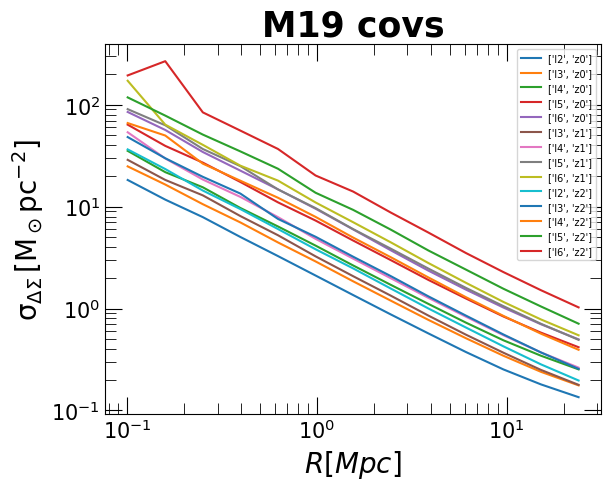

In [15]:
import glob
Rp = np.loadtxt(rp_path+'rp_hiMpc.dat')[:, 2]
sel = Rp > 0.1
cov_loc = '/global/u2/t/titus/Titus/Lensing/data/McClintock_data/desy1_SAC/'
lensing_loc = '/global/u2/t/titus/Titus/Lensing/data/McClintock_data/desy1_tamas/'
sac_files = sorted(glob.glob(cov_loc+f"SAC*")) # phys mpc profiles
sac_files[0][-6:-4]
sac_files[0][-9:-7]
sac_files

for cov in sac_files:
    sac = np.loadtxt(cov)
    diag = np.sqrt(np.diag(sac))
    plt.loglog()
    plt.plot(Rp[sel], diag[sel], label = f'{[cov[-6:-4], cov[-9:-7]]}')
plt.title("M19 covs", fontsize=25)
plt.xlabel(r"$R [Mpc]$", fontsize=20)
plt.ylabel(r"$\rm \sigma_{\Delta\Sigma}\,[M_\odot \mathrm{pc}^{-2}]$", fontsize=20)
# plt.ylabel(r"$\rm \Delta\Sigma\,[M_\odot \mathrm{pc}^{-2} \mathrm{h}^{-2}]$", fontsize=20)
plt.legend(fontsize=7)
plt.show()